In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
import json
import os
import datetime
import nrrd
import bg_space as bg
from pprint import pprint
from matplotlib.colors import LogNorm, Normalize
import seaborn as sb
import pathlib
from bg_atlasapi import BrainGlobeAtlas
from lcm_registration import LCM_registration_functions as lrf
from lcm_registration import visualign_functions as vis
from znamutils import slurm_it
from PIL import Image
import os


Run the below code to make LCM section images conform to requirements for lcm registration pipeline

In [2]:

input_folder = '/nemo/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/LCM/sections_same_orientation/'
output_folder = '/nemo/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/LCM/sections_QuickNII/'

lrf.convert_tif_to_jpg(input_folder, output_folder)

In [10]:
#remove mouse name from section images filename.
mouse_name = 'FIAA45.6D'
for filename in os.listdir(input_folder):
    if filename.startswith(f"{mouse_name}_") and filename.endswith(".TIF"):
        # Construct the new filename by removing "FIAA45_"
        new_filename = filename.replace(f"{mouse_name}_", "")
        
        # Rename the file
        os.rename(os.path.join(input_folder, filename), os.path.join(input_folder, new_filename))
        print(f"Renamed {filename} to {new_filename}")

Renamed FIAA45.6D_S038.TIF to S038.TIF
Renamed FIAA45.6D_S029.TIF to S029.TIF


Now calculate z distance between sections

In [48]:
#lcm_aligned_dir = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_V1_MAPseq/BRAC8198.6c/LCM_registration/reference/051223_final.json'
lcm_aligned_dir = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM/sections_QuickNII/050224_quicknii_visualign_final.json'

In [2]:
#lcm_dir = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_V1_MAPseq/BRAC8198.6c/LCM_registration'

Convert each registered section image to numpy file containing 2D allen ccf coordinates

In [52]:
convert_job =lrf.convert_images(lcm_aligned_dir= lcm_aligned_dir, overwrite = 'yes', use_slurm=True, slurm_folder='/camp/home/turnerb/slurm_logs')

Now find find the pixels in the previous section with closest Euclidean distance, in order to calculate z-distance between the two sections

In [2]:
#lrf.get_euclidean_distance(lcm_dir, use_slurm=True, job_dependency=convert_job, slurm_folder='/camp/home/turnerb/slurm_logs')
lcm_dir = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM'
lrf.get_euclidean_distance(lcm_dir, use_slurm=False, slurm_folder='/camp/home/turnerb/slurm_logs')

sending job for S026
sending job for S008
sending job for S039
sending job for S051
sending job for S042
sending job for S049
sending job for S022
sending job for S044
sending job for S041
sending job for S028
sending job for S050
sending job for S025
sending job for S043
sending job for S030
sending job for S023
sending job for S032
sending job for S038
sending job for S046
sending job for S033
sending job for S003
sending job for S018
sending job for S009
sending job for S048
sending job for S007
sending job for S017
sending job for S027
sending job for S019
sending job for S006
sending job for S047
sending job for S001
sending job for S031
sending job for S036
sending job for S034
sending job for S029
sending job for S020
sending job for S005
sending job for S035
sending job for S054
sending job for S021
sending job for S024
sending job for S040
sending job for S004
sending job for S052
sending job for S002
sending job for S045
sending job for S037
sending job for S053


In [2]:
lcm_dir = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM'

In [3]:
add_z = lrf.get_z_value(lcm_dir=lcm_dir, euclidean = 'no', s='upper')

/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/lcm_registration/LCM_registration_functions.py:190: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z= add_z.append({'slice': slice_name, 'amountz': dif},ignore_index=True)
/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/lcm_registration/LCM_registration_functions.py:190: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z= add_z.append({'slice': slice_name, 'amountz': dif},ignore_index=True)
/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/lcm_registration/LCM_registration_functions.py:190: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z= add_z.append({'slice': slice_name, 'amountz': dif},ignore_index=True)
/nemo/lab/znamen

In [5]:
%matplotlib inline
section = 50
euclid_dist = np.load(f'{lcm_dir}/allenccf/allen_ccf_coord/euclid_distance_S0{section}.npy')
z_dist = np.load(f'{lcm_dir}/allenccf/allen_ccf_coord/z_add_s0{section}.npy')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
sb.heatmap(euclid_dist, ax=axs[0, 0])
axs[0, 0].set_title('Nearest Euclidian distance')
sb.heatmap(z_dist, ax=axs[0, 1])
axs[0, 1].set_title('Z distance')
img1 = plt.imread(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM_registration/sections/S0{section}.TIF')
axs[1, 0].imshow(img1)
axs[1, 0].axis('off')
axs[1, 0].set_title('Section looked at')
img2 = plt.imread(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM_registration/sections/S0{section+1}.TIF')

axs[1, 1].imshow(img2)
axs[1, 1].axis('off')
axs[1, 1].set_title('Section before')
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM/allenccf/allen_ccf_coord/euclid_distance_S050.npy'

<AxesSubplot:>

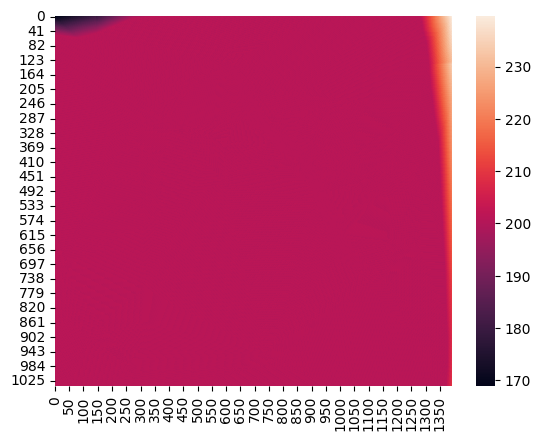

In [19]:
sb.heatmap(z_dist)

In [8]:
lcm_dir

'/camp/lab/znamenskiyp/home/shared/projects/turnerb_V1_MAPseq/BRAC8198.6c/LCM_registration'

In [7]:
#now load ROI's to visualise
ROI_path = pathlib.Path(lcm_dir)/'rois'

In [10]:
#get e.g. of ROI
for ROI_to_look in os.listdir(ROI_path):
#region = ROI_path/'s015_TUBE6.png'
    region = ROI_path/ROI_to_look
    if ROI_to_look.startswith('s0') or ROI_to_look.startswith('S0'):
        slicename = region.stem[1:4]

In [19]:
[xa, ya, za, one] = np.load(f'{lcm_dir}/allenccf/allen_ccf_coord/allen_ccf_converted_s{slicename}.npy')

In [ ]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=10)
avg_temp, meta = mcc.get_template_volume()
empty_frame = np.zeros((avg_temp.shape))

In [45]:
for file in lcm_dir

In [13]:
#now load ROI's to visualise
ROI_path = pathlib.Path(lcm_dir)/'rois'
pixcoord = []
for i, axis in enumerate([allencoord_roixa, allencoord_roiya, allencoord_roiza]):
    pixel = np.array(np.round(axis/10), dtype=int)
    pixel[pixel <0] = 0
    pixel[pixel >= empty_frame.shape[i]] = 0
    pixcoord.append(pixel)
new_coord = np.zeros(pixcoord[0].shape)
z_add=0
for stack in range(int(np.round(z_to_add/10))):
    for i in range(pixcoord[0].shape[0]):
        for j in range(pixcoord[0].shape[1]):
            if pixcoord[0][i, j] != 0:
                new_coord[i,j] = (pixcoord[0][i, j])-z_add
    z_add = z_add+1
    for k in range(pixcoord[0].shape[0]):
        for l in range(pixcoord[0].shape[1]):
            x = new_coord[k, l]
            y = pixcoord[1][k, l]
            z = pixcoord[2][k, l]
            if x != 0 and y != 0 and z != 0:
                empty_frame[int(x), int(y), int(z)] = int(tube)

NameError: name 'allencoord_roixa' is not defined

In [ ]:
#get e.g. of ROI
for ROI_to_look in os.listdir(ROI_path):
#region = ROI_path/'s015_TUBE6.png'
    region = ROI_path/ROI_to_look
    if ROI_to_look.startswith('s0') or ROI_to_look.startswith('S0'):
        slicename = region.stem[1:4]
        tube = region.stem[5:len(region.stem)].split('TUBE', 1)[1]
        #if int(tube) in cortical_samples_table['Tube'].to_list():
        [xa, ya, za, one] = np.load(reg_dir/f'allen_ccf_converted_s{slicename}.npy')
        roi = plt.imread(ROI_path/f'{region}')
        allencoord_roiya = roi*ya
        allencoord_roiza = roi*za
        allencoord_roixa= roi*xa
        z_dist = np.load(f'{lcm_dir}/allenccf/allen_ccf_coord/z_add_s{slicename}.npy')/10 #convert to 10um pixels
        
        add_z.loc[add_z['slice'] == f's{slicename}', 'amountz'].iloc[0]

        

In [11]:
reg_dir = pathlib.Path(f'{lcm_dir}/allenccf/allen_ccf_coord/')
z_averages = []
for file in reg_dir.glob("z_add_s*.npy"):
    z_file = np.load(file)
    z_av = np.mean(z_file)
    z_averages.append(z_av)
average_z = np.mean(z_averages)
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=10)
avg_temp, meta = mcc.get_template_volume()
empty_frame = np.zeros((avg_temp.shape))
    

In [9]:
#get e.g. of ROI
for ROI_to_look in os.listdir(ROI_path):
#region = ROI_path/'s015_TUBE6.png'
    region = ROI_path/ROI_to_look
    if ROI_to_look.startswith('s0') or ROI_to_look.startswith('S0'):
        slicename = region.stem[1:4]
        tube = region.stem[5:len(region.stem)].split('TUBE', 1)[1]
        #if int(tube) in cortical_samples_table['Tube'].to_list():
        [xa, ya, za, one] = np.load(reg_dir/f'allen_ccf_converted_s{slicename}.npy')
        roi = plt.imread(ROI_path/f'{region}')
        allencoord_roiya = roi*ya
        allencoord_roiza = roi*za
        allencoord_roixa= roi*xa
        z_file = reg_dir/f'z_add_s{slicename}.npy'
        if z_file.is_file():
            z_dist = np.load(z_file)
                
            z_dist_pix = np.round(z_dist/10)
            #convert the x, y, z coordinates to pixel
            
            pixcoord = []
            for i, axis in enumerate([allencoord_roixa, allencoord_roiya, allencoord_roiza]):
                pixel = np.array(np.round(axis/10), dtype=int)
                pixel[pixel <0] = 0
                pixel[pixel >= empty_frame.shape[i]] = 0
                pixcoord.append(pixel)
            for i in range(pixcoord[0].shape[0]):
                for j in range(pixcoord[0].shape[1]):
                    if pixcoord[0][i, j] != 0:
                        for z_add in range(int(z_dist_pix[i, j])):
                            x = pixcoord[0][i, j] - z_add
                            y = pixcoord[1][i, j]
                            z = pixcoord[2][i, j]
                            if x != 0 and y != 0 and z != 0:
                                empty_frame[int(x), int(y), int(z)] = int(tube)
        elif z_file.is_file()==False:
            average_z_pix = np.round(average_z/10)
            for i in range(pixcoord[0].shape[0]):
                for j in range(pixcoord[0].shape[1]):
                    if pixcoord[0][i, j] != 0:
                        for z_add in range(int(average_z_pix)):
                            x = pixcoord[0][i, j] - z_add
                            y = pixcoord[1][i, j]
                            z = pixcoord[2][i, j]
                            if x != 0 and y != 0 and z != 0:
                                empty_frame[int(x), int(y), int(z)] = int(tube)
                # new_coord[i,j] = (pixcoord[0][i, j])-z_add

In [10]:
np.save(f'{lcm_dir}/ROI_flatmap.npy', empty_frame)